# **This note book accompanies the article: [Neo4j & DGL — a seamless integration]((https://towardsdatascience.com/neo4j-dgl-a-seamless-integration-624ad6edb6c0)), and implements a Graph Attention Network, (Veličković et al., ICLR 2018): https://arxiv.org/abs/1710.10903, using the Deep Graph Library, [DGL](https://www.dgl.ai/), with TensorFlow 2.x as backend and Neo4j to write and store the graph** 

In [ ]:
#To ensure that DGL can access GPU hardware; make sure to install CUDA10, 
#as per the following:
!pip3 install dgl-cu100 

!pip install neo4j

     |████████████████████████████████| 24.6MB 120kB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
  Created wheel for neo4j: filename=neo4j-4.2.1-cp37-none-any.whl size=95190 sha256=bee8cdccc47991127ef12289d486517145de262fd1e5114e715439284b4e79d1
  Stored in directory: /root/.cache/pip/wheels/00/a8/69/083e04c2ffc0a7e026c9356cd5bb54c65128f3e08ef8371be0
Successfully built neo4j


To connect to Neo4j we create a Sandbox instance:
https://sandbox.neo4j.com/

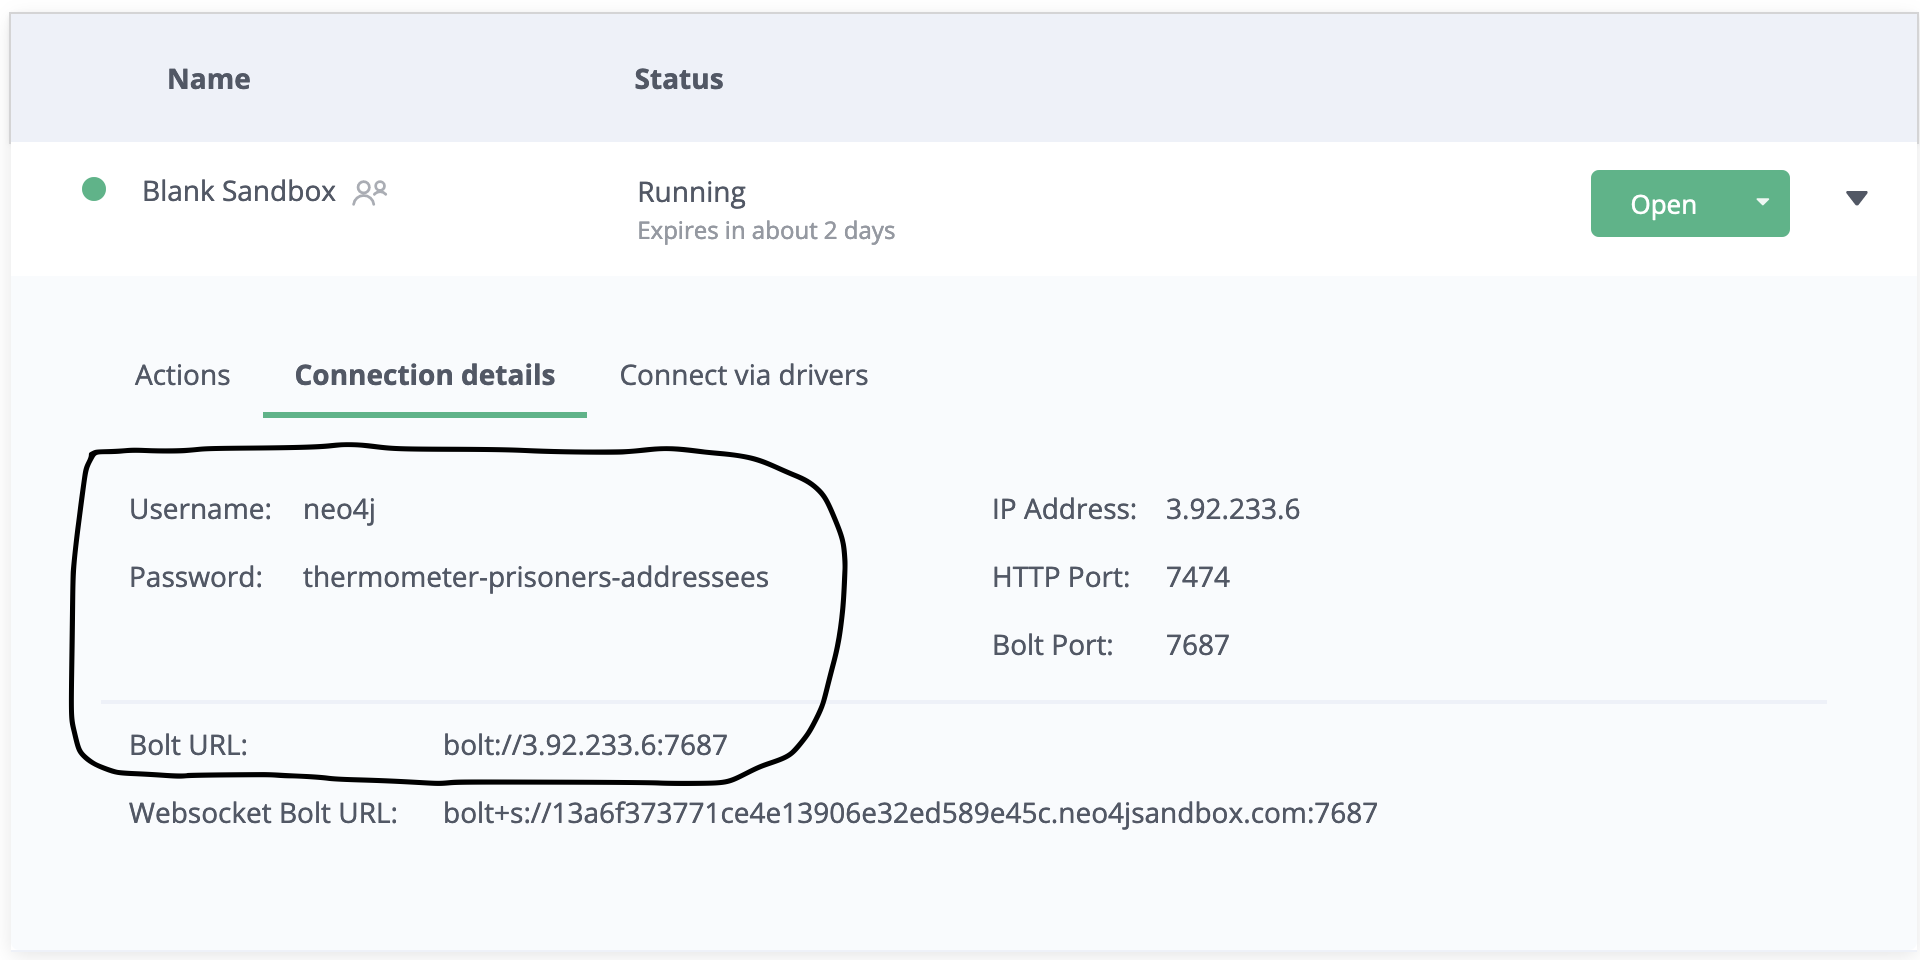

In [ ]:
#Assign the connection details to variables for use in the Neo4j Driver

uri = "bolt://3.86.108.28:7687"
user = "neo4j"
pasw = "debris-transits-arcs"

For this exercise we decided to use TensorFlow as backend. PyTorch examples can be found on [www.DGL.ai](https://www.DGL.ai) 

In [ ]:

#In order to make sure TensorFlow is being used as a backend, assign before 
#importing dgl, as follows:

import os  
os.environ["DGLBACKEND"] = "tensorflow"

In [ ]:
import argparse
import numpy as np
import networkx as nx
import time
import pandas as pd
import matplotlib.pyplot as plt


from neo4j import GraphDatabase

import dgl
import dgl.function as fn
from dgl.nn import GATConv
from dgl.data import register_data_args
from dgl.data import CoraGraphDataset

import tensorflow as tf
from tensorflow.keras import layers

from functools import reduce  

Using backend: tensorflow


The data set used is the Cora citation graph. For this experiment we have used the Cora dataset hosted by DGL and load this in the cell here below.  
The original dataset can be found [here](http://www.cs.umd.edu/~sen/lbc-proj/LBC.html)


In [ ]:
#Loading the Cora graph from DGL

CoraGraphDataset() 

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
#The following block is to produce an edge list such to create the Cora graph 
#in Neo4j using the Python drivers 

import pickle as pkl
import sys


def _pickle_load(pkl_file):
    if sys.version_info > (3, 0):
        return pkl.load(pkl_file, encoding='latin1')
    else:
        return pkl.load(pkl_file)



root = '/root/.dgl/cora_v2'
objnames = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
objects = []
for i in range(len(objnames)):
    with open("{}/ind.{}.{}".format(root, 'cora_v2', objnames[i]), 'rb') as f:
        objects.append(_pickle_load(f))

x, y, tx, ty, allx, ally, graph = tuple(objects)

edge_lst = []
for id in graph.keys():
    for edge_id in graph[id]:
        edge_lst.append((id, edge_id))

print(edge_lst)

[(0, 633), (0, 1862), (0, 2582), (1, 2), (1, 652), (1, 654), (2, 1986), (2, 332), (2, 1666), (2, 1), (2, 1454), (3, 2544), (4, 2176), (4, 1016), (4, 2176), (4, 1761), (4, 1256), (4, 2175), (5, 1629), (5, 2546), (5, 1659), (5, 1659), (6, 1416), (6, 1602), (6, 1042), (6, 373), (7, 208), (8, 281), (8, 1996), (8, 269), (9, 2614), (9, 723), (9, 723), (10, 476), (10, 2545), (11, 1655), (11, 1839), (12, 2661), (12, 1001), (12, 1318), (12, 2662), (13, 1810), (13, 1701), (14, 2034), (14, 2075), (14, 158), (14, 2077), (14, 2668), (15, 2367), (15, 1093), (15, 1090), (15, 1271), (15, 1093), (16, 2444), (16, 1632), (16, 970), (16, 2642), (17, 24), (17, 2140), (17, 1316), (17, 1315), (17, 927), (18, 2082), (18, 139), (18, 1786), (18, 1560), (18, 2145), (19, 1939), (20, 1072), (20, 2374), (20, 2375), (20, 2269), (20, 2270), (21, 1043), (21, 2310), (22, 1703), (22, 1702), (22, 2238), (22, 39), (22, 1234), (23, 2159), (24, 1701), (24, 2139), (24, 1636), (24, 17), (24, 2141), (24, 598), (24, 201), (25, 

In [ ]:
#Instantiating the Neo4j Python driver:
driver = GraphDatabase.driver(uri=uri, auth=("neo4j", pasw))
with driver.session() as session:
  session.run("create constraint on (p:Paper) assert p.id is unique")

In [ ]:
#Adding graph to Neo4j
def add_graph(tx, items):
  tx.run(add_graph_query, items=items)

add_graph_query = '''
UNWIND $items AS item
MERGE (f:Paper {id: item.id})
MERGE (e:Paper {id: item.edge_id})
MERGE (f)-[:CITED_BY]-(e)
'''
params = {"id": int(id), "edge_id": int(edge_id)}
items = []
with driver.session() as session:
    for id, edge_id in edge_lst:
        items.append({"id": int(id), "edge_id": int(edge_id)})
        if len(items) % 1000 == 0:
          session.write_transaction(add_graph, items)
          items=[]
    session.write_transaction(add_graph, items)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def step(self, acc, model):
        score = acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        '''Saves model when validation loss decrease.'''
        model.save_weights('es_checkpoint.pb')

class NoEarlyStopping:
  def step(self, acc, model):
    return False        

In [ ]:
class GAT(tf.keras.Model):
    def __init__(self,
                 g,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 activation,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT, self).__init__()
        self.g = g
        self.num_layers = num_layers
        self.gat_layers = []
        self.activation = activation

        # input projection (no residual)
        self.gat_layers.append(GATConv(
            in_dim, num_hidden, heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(GATConv(
                num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, negative_slope, residual, self.activation))
        
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden * heads[-2], num_classes, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))

    def call(self, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](self.g, h)
            h = tf.reshape(h, (h.shape[0], -1))
        
        # output projection
        logits = tf.reduce_mean(self.gat_layers[-1](self.g, h), axis=1)
        return logits

In [ ]:
def accuracy(logits, labels):
    indices = tf.math.argmax(logits, axis=1)
    acc = tf.reduce_mean(tf.cast(indices == labels, dtype=tf.float32))
    return acc.numpy().item()

In [ ]:
def evaluate(model, features, labels, mask):
    logits = model(features, training=False)
    logits = logits[mask]
    labels = labels[mask]
    return accuracy(logits, labels)


In [ ]:
def create_model(data, g, features, args):
  heads = ([args["num_heads"]] * args["num_layers"]) + [args["num_out_heads"]]
  n_classes = data.num_labels
  num_feats = features.shape[1]

  return GAT(g, 
             args["num_layers"],
             num_feats,
             args["num_hidden"],
             n_classes,
             heads,
             tf.nn.elu,
             args["in_drop"],
             args["attn_drop"],
             args["negative_slope"],
             args["residual"])


def compute_loss_value(tape, model, labels, logits, train_mask, args):
  optimizer = tf.keras.optimizers.Adam(learning_rate=args["lr"], epsilon=1e-8)
  loss_fcn = tf.nn.sparse_softmax_cross_entropy_with_logits
  loss_value = reduce(
      lambda loss_value, weight: loss_value + args["weight_decay"]*tf.nn.l2_loss(weight), 
      model.trainable_weights,
      tf.reduce_mean(loss_fcn(labels=labels[train_mask], logits=logits[train_mask])))

  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  return loss_value 

def log_progress(data, g, epoch, dur, loss_value, train_acc, val_acc):
  n_edges = data.graph.number_of_edges()
  n_edges = g.number_of_edges()
  print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | TrainAcc {:.4f} |"
        " ValAcc {:.4f} | ETputs(KTEPS) {:.2f}".
        format(epoch, np.mean(dur), loss_value.numpy().item(), train_acc,
                val_acc, n_edges / np.mean(dur) / 1000))

def train(args):
    data = args["dataset"]
    g = data[0]
    print("g", g)
    if args["gpu"] < 0:
        device = "/cpu:0"
    else:
        device = "/gpu:{}".format(args["gpu"])
        g = g.to(device)

    g = dgl.remove_self_loop(g)
    g = dgl.add_self_loop(g)

    with tf.device(device):
        features = g.ndata['feat']        
        model = create_model(data, g, features, args)

        labels = g.ndata['label']
        train_mask = g.ndata['train_mask']                        
        stopper = EarlyStopping(patience=100) if args["early_stop"] else NoEarlyStopping()
        


        dur = []
        acc_plt = []
        ValAcc_lst = []
        loss_lst = []
        epoch_lst = []
        for epoch in range(args["epochs"]):
            if epoch >= 3:
                t0 = time.time()

            # forward
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_weights)
                logits = model(features, training=True)
                loss_value = compute_loss_value(tape, model, labels, logits, train_mask, args)
                loss_lst.append(loss_value.numpy().item())            

            if epoch >= 3:
                dur.append(time.time() - t0)

            train_acc = accuracy(logits[train_mask], labels[train_mask])
            acc_plt.append(train_acc) 
            epoch_lst.append(epoch)
             
            
            val_mask = g.ndata['val_mask']         
            val_acc = accuracy(logits[val_mask], labels[val_mask]) if args["fastmode"] else evaluate(model, features, labels, val_mask)
            ValAcc_lst.append(val_acc)

            if stopper.step(val_acc, model):
              break

            log_progress(data, g, epoch, dur, loss_value, train_acc, val_acc)

        
        actual_labels = ['Case_Based', 'Probabilistic_Methods', 'Theory','Genetic_Algorithms','Rule_Learning','Reinforcement_Learning','Neural_Networks']
       
        #Creating the plots
        
        plt.style.use('seaborn-whitegrid')


        x_plt = epoch_lst 
        y1_plt = acc_plt
        y2_plt = ValAcc_lst
        y3_plt = loss_lst

        fig, ax = plt.subplots(1,2, figsize=(17,10))
        ax[0].plot(x_plt, y1_plt, label='Train accuracy')
        ax[0].plot(x_plt, y2_plt, label='Validation accuracy')
        ax[1].plot(x_plt, y3_plt, label='Loss')

        ax[0].set(xlabel='epochs', ylabel='Accuracy',
                title='GAT train & validation accuracy')
        ax[0].legend(loc='best')
        ax[0].axis([0, 375, 0.4,0.9])
        #ax[0].grid()

        ax[1].set(xlabel='epochs', ylabel='Loss', title='GAT loss')
        #ax[1].grid()


        fig.savefig("/content/GAT_plot.png")
        plt.show()




        print('______________________________________________________________')
        if args["early_stop"]:
            model.load_weights('es_checkpoint.pb')
        
        test_mask = g.ndata['test_mask']      
        acc = evaluate(model, features, labels, test_mask)

        #writing actual labels to CSV can be commented out, inserted as backup
        f = open('actual_labels.csv', "w") 
        df_actual_labels = pd.DataFrame(columns=['Node_id', 'Actual_Label'])
        for node_id, actual_label in enumerate(labels):
            f.write(f'{node_id},{actual_labels[actual_label]}\n')
            row = pd.DataFrame([[node_id, actual_labels[actual_label]]], columns=['Node_id', 'Actual_Label'])
            df_actual_labels = df_actual_labels.append(row)
         
        print("Test Accuracy {:.4f}".format(acc))

        #Assigning the one-hot encoding to the actual classes
        model_output = model(features, training=False)
        idx_label = tf.math.argmax(model_output, axis=1)

        #writing to file can be commented out, backup only
        f = open('predicted_labels.csv', "w")
        df_pred_labels = pd.DataFrame(columns=['Node_id', 'Predicted_Label'])
        for node_id, predicted_label in enumerate(idx_label):
             f.write(f'{node_id},{actual_labels[predicted_label]}\n')
             row = pd.DataFrame([[node_id, actual_labels[predicted_label]]], columns=['Node_id', 'Predicted_Label'])
             df_pred_labels = df_pred_labels.append(row)

       
        return df_actual_labels, df_pred_labels

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
g Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=tf.bool), 'val_mask': Scheme(shape=(), dtype=tf.bool), 'test_mask': Scheme(shape=(), dtype=tf.bool), 'label': Scheme(shape=(), dtype=tf.int64), 'feat': Scheme(shape=(1433,), dtype=tf.float32)}
      edata_schemes={})
Epoch 00000 | Time(s) nan | Loss 1.9953 | TrainAcc 0.1857 | ValAcc 0.3480 | ETputs(KTEPS) nan


/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:285: UserWarning: Property dataset.num_labels will be deprecated, please use dataset.num_classes instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:285: UserWarning: Property dataset.graph will be deprecated, please use dataset[0] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00001 | Time(s) nan | Loss 1.9873 | TrainAcc 0.2571 | ValAcc 0.4960 | ETputs(KTEPS) nan
Epoch 00002 | Time(s) nan | Loss 1.9780 | TrainAcc 0.3571 | ValAcc 0.5820 | ETputs(KTEPS) nan
Epoch 00003 | Time(s) 0.0334 | Loss 1.9691 | TrainAcc 0.4000 | ValAcc 0.6540 | ETputs(KTEPS) 396.79
Epoch 00004 | Time(s) 0.0326 | Loss 1.9565 | TrainAcc 0.4786 | ValAcc 0.6880 | ETputs(KTEPS) 407.33
Epoch 00005 | Time(s) 0.0334 | Loss 1.9494 | TrainAcc 0.4786 | ValAcc 0.7200 | ETputs(KTEPS) 397.15
Epoch 00006 | Time(s) 0.0331 | Loss 1.9403 | TrainAcc 0.5857 | ValAcc 0.7400 | ETputs(KTEPS) 400.86
Epoch 00007 | Time(s) 0.0330 | Loss 1.9340 | TrainAcc 0.6000 | ValAcc 0.7640 | ETputs(KTEPS) 401.53
EarlyStopping counter: 1 out of 100
Epoch 00008 | Time(s) 0.0329 | Loss 1.9199 | TrainAcc 0.6929 | ValAcc 0.7560 | ETputs(KTEPS) 402.99
Epoch 00009 | Time(s) 0.0333 | Loss 1.9064 | TrainAcc 0.6643 | ValAcc 0.7760 | ETputs(KTEPS) 398.72
Epoch 00010 | Time(s) 0.0336 | Loss 1.9118 | TrainAcc 0.6286 | ValAcc 0.7780

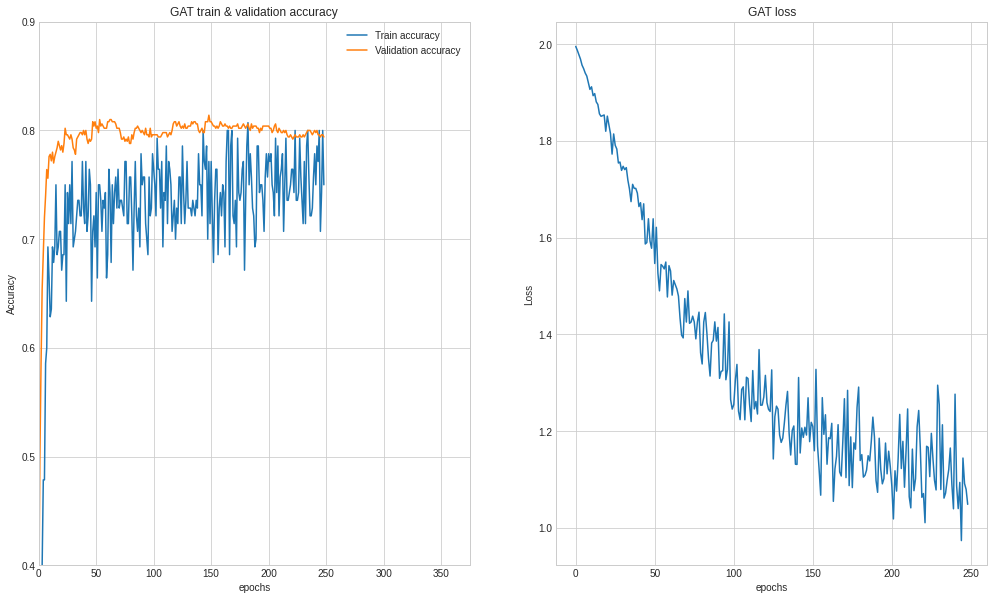

______________________________________________________________
Test Accuracy 0.8150


In [ ]:

args = {  
  "gpu": 0,
  "epochs": 500,
  "num_heads": 8,
  "num_out_heads": 1,
  "num_layers": 1,
  "num_hidden": 8,
  "residual": False,
  "in_drop":.6,
  "attn_drop": .6,
  "lr": 0.005,
  "weight_decay" :5e-4,
  "negative_slope" : 0.2,
  "early_stop": True,
  "fastmode": False,
  "dataset": CoraGraphDataset()  
  }


df_actual_labels, df_pred_labels = train(args)


# Writing results back to Neo4j using Python drivers



In [ ]:
#Writing the Actual labels to Neo4j from df_pred_labels
def add_labels(tx, items):
  tx.run(add_labels_query, items=items)
add_labels_query = """
UNWIND $items AS item
MERGE (n:Paper {id: item.nodeId})
SET n.label = item.label
WITH n, item
CALL apoc.create.addLabels([n],[item.label])
YIELD node
RETURN count(*)
"""

items = []
with driver.session() as session:
    for node_id, label in zip(df_actual_labels.Node_id.values, df_actual_labels['Actual_Label']):
        items.append({"nodeId": int(node_id), "label": label})
        if len(items) % 1000 == 0:
          session.write_transaction(add_labels, items)
    session.write_transaction(add_labels, items)



In [ ]:
def add_predicted_labels(tx, items):
  tx.run(add_predicted_labels_query, items=items)
add_predicted_labels_query = """
UNWIND $items AS item
MERGE (n:Paper {id: item.nodeId})
SET n.Predicted_Label = item.Predicted_Label       
RETURN count(*)
"""
items = []
with driver.session() as session:
    for node_id, pred_label in zip(df_pred_labels.Node_id.values, df_pred_labels['Predicted_Label']):
        items.append({"nodeId": int(node_id) , "Predicted_Label": pred_label})
        if len(items) % 1000 == 0:
          session.write_transaction(add_predicted_labels, items)
    session.write_transaction(add_predicted_labels, items)